In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, roc_auc_score

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('clean_vizathon.csv', index_col=0)

/Users/jared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
display(df.head(3))
print(df.shape)

,index,game_id,season,day_num,date,team_id,team_name,team_city,team_state,team_dist_from_home,...,opp_blks,opp_pfs,opp_poss,opp_elo_before_game,opp_elo_after_game,opp_elo_win_prob,team_off_eff,team_def_eff,opp_off_eff,opp_def_eff
0,184715,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1328,Oklahoma,Norman,OK,,...,1,22,47,700.0,712.0,0.5,100.000000,109.677419,109.677419,100.000000
1,184714,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1104,Alabama,Tuscaloosa,AL,,...,2,20,48,700.0,688.0,0.5,109.677419,100.000000,100.000000,109.677419
2,161722,2003_2002-11-14_1272_1393,2003,10,2002-11-14,1272,Memphis,Memphis,TN,,...,6,16,64,700.0,688.0,0.5,83.333333,75.000000,75.000000,83.333333


(184940, 58)


In [4]:
df = df.applymap(lambda x:  x.strip() if isinstance(x, str) else x)

#### Note:
Each game is basically duplicated with the two opposing teams each considered once 'team' and once 'opponent'. 

These should be removed.

In [5]:
df.drop_duplicates(subset='game_id',inplace=True)

In [6]:
df.shape

(92470, 58)

Check class balance:

In [7]:
n_samples = df.shape[0]
n_wins = sum(df.team_win)
win_dist = n_wins / n_samples

print("n samples: ", n_samples)
print("n wins: ", n_wins)
print("'win' class distribution: ", round(win_dist, 3))

n samples:  92470
n wins:  46072
'win' class distribution:  0.498


Very even.

In [8]:
# Engineer simple column, 'difference between elo'
df['team_diff_elo'] = df.team_elo_before_game - df.opp_elo_before_game
# preview
df[['team_elo_before_game', 'opp_elo_before_game', 'team_diff_elo']].iloc[200:205]

,team_elo_before_game,opp_elo_before_game,team_diff_elo
398,700.0,688.000000,12.000000
400,700.0,700.000000,0.000000
402,688.0,713.102126,-25.102126
404,688.0,700.000000,-12.000000
407,700.0,712.000000,-12.000000


In [9]:
df['team_fg_percent'] = df['team_fgm'] / df['team_fga']
df['opp_fg_percent'] = df['opp_fgm'] / df['opp_fga']

df['team_3p_percent'] = df['team_3pm'] / df['team_3pa']
df['opp_3p_percent'] = df['opp_3pm'] / df['opp_3pa']


df['team_ft_percent'] = df['team_ftm'] / df['team_fta']
df['opp_ft_percent'] = df['opp_ftm'] / df['opp_fta']



### Running averages for stats each season

Each season is considered a fresh slate. 

However, if it is the first game of the season, the final average of the previous season is used.

By the second game, the performance from the first game will be the new and only term in the running average.

In [10]:
def rolling_avg_per_season(df, df_grouped, col: str):
    "Return df with column 'avg_{col}' based on the rolling average of df[col] per season"
    gg = df_grouped[col].rolling(window=365, freq='D',min_periods=1).mean().reset_index()
    return df.merge(gg.rename(columns={col: "avg_"+col}))

In [11]:
cols_to_avg = ['opp_def_eff', 'team_off_eff', 'team_fg_percent', 'team_def_rebs', 'team_asts', 'team_3p_percent',
               'opp_off_eff', 'team_def_eff', 'opp_fg_percent', 'opp_def_rebs', 'opp_asts', 'opp_3p_percent']

col_map = {col: "avg_"+col for col in cols_to_avg}
col_include = [v for v in col_map.values()]

In [12]:
df_grouped = df.set_index('game_id').groupby(['team_id', 'season'])

In [13]:
gg = df_grouped[cols_to_avg].rolling(window=2, min_periods=1).mean().shift().reset_index()
gg.rename(columns=col_map, inplace=True)

In [14]:
gg[gg.isnull().any(axis=1)]

,team_id,season,game_id,avg_opp_def_eff,avg_team_off_eff,avg_team_fg_percent,avg_team_def_rebs,avg_team_asts,avg_team_3p_percent,avg_opp_off_eff,avg_team_def_eff,avg_opp_fg_percent,avg_opp_def_rebs,avg_opp_asts,avg_opp_3p_percent
0,1101,2014,2014_2013-11-09_1182_1101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df2 = df.merge(gg.dropna(axis=0, how='any'))

### Create a simple logistic regression model.

The baseline accuracy is 70% (simple Elo win probability).

To make statistcal inferences about the model's coefficients, must verify assumptions:
1. Dependent variable(win/lose) is binary. 
2. Observations must be independent of each other (no matched data, e.g. delete duplicate game IDs)
3. Multicollinearity must be small or none  among the independent variables
4. Independent variables are linearly related to the log odds (not to dependent variable)
5. Large enough sample size for number of independent variables considered

In [43]:
col_include

['avg_opp_def_eff',
 'avg_team_off_eff',
 'avg_team_fg_percent',
 'avg_team_def_rebs',
 'avg_team_asts',
 'avg_team_3p_percent',
 'avg_opp_off_eff',
 'avg_team_def_eff',
 'avg_opp_fg_percent',
 'avg_opp_def_rebs',
 'avg_opp_asts',
 'avg_opp_3p_percent']

In [44]:
columns = col_include + ['team_elo_win_prob']
X = df2[columns]
y = df2.team_win

X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train.hist(bins=30, figsize=(14, 8))

In [45]:
X_train.corrwith(y_train)

avg_opp_def_eff        0.124170
avg_team_off_eff       0.124170
avg_team_fg_percent    0.114624
avg_team_def_rebs      0.071213
avg_team_asts          0.115121
avg_team_3p_percent    0.051823
avg_opp_off_eff       -0.124691
avg_team_def_eff      -0.124691
avg_opp_fg_percent    -0.102693
avg_opp_def_rebs      -0.093338
avg_opp_asts          -0.097324
avg_opp_3p_percent    -0.042645
team_elo_win_prob      0.478327
dtype: float64

In [46]:
LR = LogisticRegression(random_state=10)
LR.fit(X_train, y_train)

y_train_preds = LR.predict(X_train)

In [47]:
print('accuracy_score: ', accuracy_score(y_train, y_train_preds))
print('recall_score: ', recall_score(y_train, y_train_preds))
print('precision_score: ', precision_score(y_train, y_train_preds))

accuracy_score:  0.7011578780406915
recall_score:  0.6986436355205193
precision_score:  0.7000842215316702


Text(0, 0.5, "Difference from Opponent's Elo")

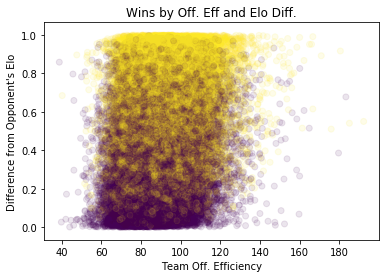

In [21]:
fig, ax = plt.subplots()

ax.scatter(X_train['avg_team_off_eff'], X_train['team_elo_win_prob'], c=y_train, alpha=.1)
ax.set_title('Wins by Off. Eff and Elo Diff.')
ax.set_xlabel('Team Off. Efficiency')
ax.set_ylabel("Difference from Opponent's Elo")

In [29]:
feat_coef = pd.DataFrame(index=X.columns, data=LR.coef_[0], columns=['LR_coef'])
feat_coef['abs_coef'] = abs(feat_coef['LR_coef'])
feat_coef.sort_values(by='abs_coef', ascending=False)

,LR_coef,abs_coef
team_elo_win_prob,3.941556,3.941556
avg_team_3p_percent,-0.778352,0.778352
avg_team_fg_percent,-0.570325,0.570325
avg_opp_fg_percent,-0.356932,0.356932
avg_opp_3p_percent,0.266298,0.266298
avg_team_asts,0.019578,0.019578
avg_team_def_rebs,-0.017273,0.017273
avg_opp_def_rebs,-0.009288,0.009288
avg_opp_off_eff,-0.003926,0.003926
avg_team_def_eff,-0.003926,0.003926


In [30]:
y_pred = LR.predict(X_test)

In [31]:
print('accuracy_score: ', accuracy_score(y_test, y_pred))
print('recall_score: ', recall_score(y_test, y_pred))
print('precision_score: ', precision_score(y_test, y_pred))

accuracy_score:  0.6974219223116187
recall_score:  0.6948859709744298
precision_score:  0.6990527504996958


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     11542
           1       0.70      0.69      0.70     11576

    accuracy                           0.70     23118
   macro avg       0.70      0.70      0.70     23118
weighted avg       0.70      0.70      0.70     23118



In [33]:
### create Elo prediction model for Baseline

In [39]:
### create Elo prediction model

class Elo():
    """
    Make simple Elo predictions from equation. Only use elo ratings to predict outcome.
    """
    
    def __init__(self, elo_diff_col='team_diff_elo',
                    team_elo_col='team_elo_before_game', opp_elo_col='opp_elo_before_game'):
        self.elo_diff_col = elo_diff_col
        self.team_elo_col = team_elo_col
        self.opp_elo_col = opp_elo_col
    
    def fit(self, X, y):
        pass
    
    def elo_win_prob(self, elo_diff):
        """
        'elo diff': array
        """
        return 1 / (1 + 10 ** ((elo_diff) / 400))
    
    def predict_proba(self, X_test):
        if not self.elo_diff_col:
            team_elo = X_test[self.team_elo_col]
            opp_elo = X_test[self.opp_elo_col]
            p =  self.elo_win_prob(opp_elo - team_elo).values
        else:
            p = self.elo_win_prob(- X_test[self.elo_diff_col]).values
        return np.array([1-p, p]).T
        
        
    def predict(self, X_test):
        win_probs = self.predict_proba(X_test)[:,1]
        return np.array([1 if x > 0.5 else 0 for x in win_probs])
          

In [42]:
X_elo = df2
y_elo = df2['team_win']

elo = Elo()
elo_pred = elo.predict(X_elo)

print("AUC:", roc_auc_score(y_elo, elo_pred))
print("Accuracy: ", accuracy_score(y_elo, elo_pred))
print("Precision: ", precision_score(y_elo, elo_pred))
print("Recall: ", recall_score(y_elo, elo_pred))

AUC: 0.6990983292149688
Accuracy:  0.6990991575555051
Precision:  0.6977117101499524
Recall:  0.6988626497655843


### Trying Multiple Models

In [50]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
 

In [51]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [52]:
def modelling(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    probs = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)

    return (precision, recall, accuracy, thresh_df, roc_auc, model)

In [53]:
# initializing models

logistic = LogisticRegression()
gb = GradientBoostingClassifier()
kn = KNeighborsClassifier()
xgb = XGBClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

# elo = Elo()

model_list = [logistic, gb, xgb, rf, dt, kn]

LogisticRegression  accuracy:  0.6963
GradientBoostingClassifier  accuracy:  0.6963
XGBClassifier  accuracy:  0.6969
RandomForestClassifier  accuracy:  0.6902
DecisionTreeClassifier  accuracy:  0.6094
KNeighborsClassifier  accuracy:  0.5413


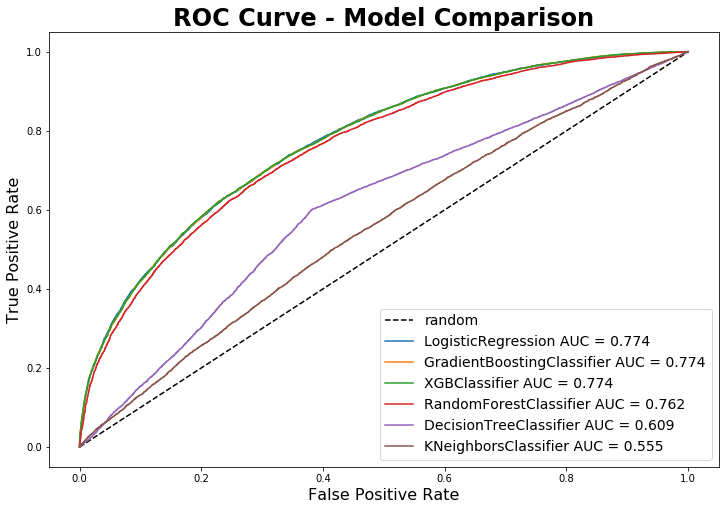

In [54]:
## Fitting and testing models
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0,1],[0,1], 'k', label="random", linestyle='--')
res_list = []

for model in model_list:
    results = modelling(X_train, X_test, y_train, y_test, model)
    res_list.append(results)
    auc_score = results[4]
    plot_roc(ax, results[3], 
             "{} AUC = {}".format(model.__class__.__name__, round(auc_score, 3)))

res_arr = np.array(res_list)
accuracies = res_arr[:, 2]
for i in range(len(model_list)):
    print(model_list[i].__class__.__name__, " accuracy: ", round(accuracies[i], 4))

### Tuning GBoosting Classifier

In [823]:
## PARAMETER SEARCH

model = GradientBoostingClassifier()

learning_rate = np.array([0.1, 0.09])
n_estimators = np.array([50, 25])
max_depth = np.array([3])

random_state = np.array([0])

parameters = {'learning_rate': learning_rate,
            'n_estimators': n_estimators,
             'max_depth': max_depth,
              'random_state': random_state}


clf = GridSearchCV(estimator=model,
                    param_grid=parameters,
                    cv=5, verbose=5)

clf.fit(X_train, y_train)

model_final = clf.best_estimator_

os.system("say 'grid search complete oh yaaaaaaaaaaaaaa' ")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0, score=0.694, total=  11.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0, score=0.700, total=  10.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0, score=0.697, total=  11.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0, score=0.702, total=  12.6s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.5s remaining:    0.0s


KeyboardInterrupt: 

In [815]:
model_final.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

In [818]:
accuracy_score(y_test, model_final.predict(X_test))

0.57375205467601

### Examine Feature importances / Coefficients:

In [714]:
def plot_importances(tree, title):
    """
    tree: a sklearn tree-based model
    """
    importances = tree.feature_importances_
#     std = np.std([t[0].feature_importances_ for t in tree.estimators_],
#                  axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(12,3))
    plt.title(title + ": Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           align="center", alpha=0.7)
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    print('\n')

#### Feature importances for tree based models

Feature ranking:
1. feature 0 (0.464520)
2. feature 5 (0.326817)
3. feature 6 (0.195342)
4. feature 1 (0.007172)
5. feature 3 (0.004242)
6. feature 2 (0.001482)
7. feature 4 (0.000425)


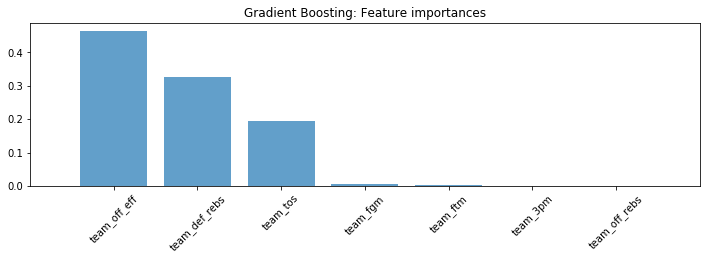



Feature ranking:
1. feature 0 (0.363971)
2. feature 5 (0.224993)
3. feature 6 (0.141061)
4. feature 1 (0.093063)
5. feature 3 (0.085096)
6. feature 4 (0.047900)
7. feature 2 (0.043915)


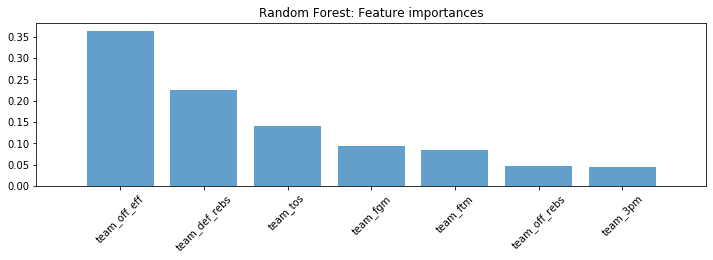



Feature ranking:
1. feature 0 (0.408445)
2. feature 5 (0.262379)
3. feature 6 (0.162449)
4. feature 1 (0.052599)
5. feature 3 (0.039690)
6. feature 4 (0.039318)
7. feature 2 (0.035120)


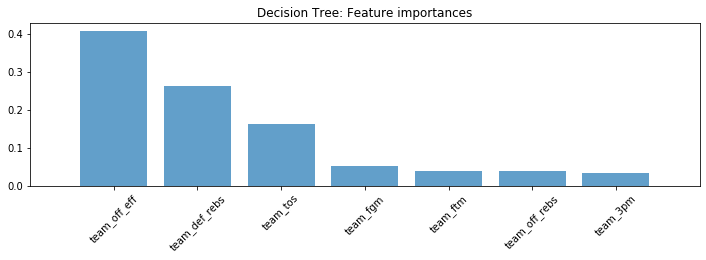

In [771]:
plot_importances(gb, "Gradient Boosting")
plot_importances(rf, "Random Forest")
plot_importances(dt, "Decision Tree")

#### Logistic Regression Coefficients

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

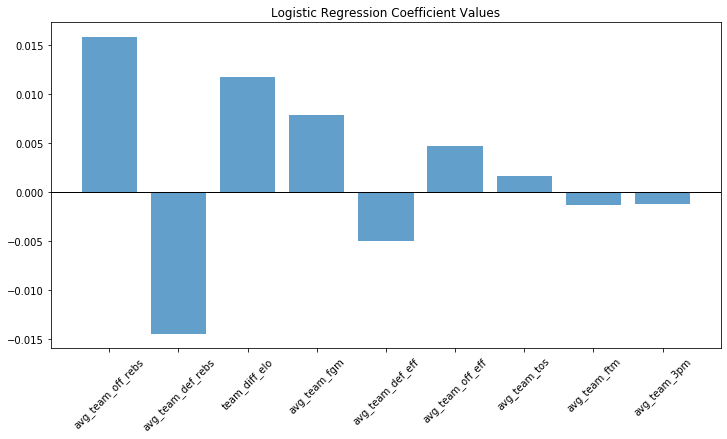

In [717]:
coefs = logistic.coef_[0]
indices = np.argsort(abs(coefs))[::-1]

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(X.columns[indices], coefs[indices], 
      align='center', alpha=0.7)
ax.set_title("Logistic Regression Coefficient Values")
ax.axhline(y=0, color='k', linewidth=1)
plt.xticks(rotation=45)


### Quick Analysis

With these features...


In [729]:
X.columns

Index(['avg_team_off_eff', 'avg_team_def_eff', 'avg_team_fgm', 'avg_team_3pm',
       'avg_team_ftm', 'avg_team_off_rebs', 'avg_team_def_rebs',
       'avg_team_tos', 'team_elo_win_prob'],
      dtype='object')

#### Different features

LogisticRegression  accuracy:  0.5745


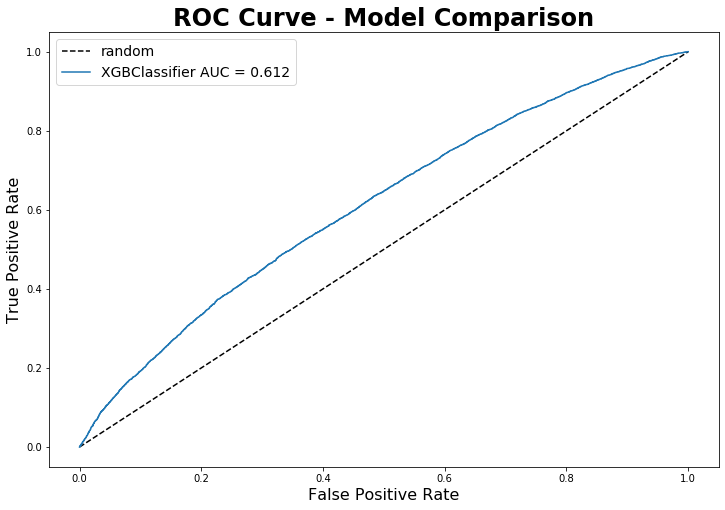

In [807]:
model_list2 = [xgb]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0,1],[0,1], 'k', label="random", linestyle='--')
res_list = []

for model in model_list2:
    results = modelling(X_train, X_test, y_train, y_test, model)
    res_list.append(results)
    auc_score = results[4]
    plot_roc(ax, results[3], 
             "{} AUC = {}".format(model.__class__.__name__, round(auc_score, 3)))

res_arr = np.array(res_list)
accuracies = res_arr[:, 2]
for i in range(len(model_list2)):
    print(model_list[i].__class__.__name__, " accuracy: ", round(accuracies[i], 4))

In [745]:
df

ValueError: invalid literal for int() with base 10: ''